In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, GRU
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from datetime import datetime
from sklearn.model_selection import train_test_split
from scipy.interpolate import UnivariateSpline
from sklearn import linear_model
import xgboost as xgb

# display for this notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
speed = pd.read_csv('/content/gdrive/My Drive/5001/individual_project/train.csv') 

In [ ]:
speed['date']=pd.to_datetime(speed['date'],format='%d/%m/%Y %H:%M')
date_range = pd.date_range("2017-01-01 00:00:00", "2017-12-31 23:00:00", freq='1H').append(
    pd.date_range("2018-01-01 00:00:00", "2018-12-31 23:00:00", freq='1H'))
speed_nan = pd.DataFrame(columns=['date', 'speed'],)
speed_nan['date'] = date_range
speed_nan['speed'] = np.nan
speed_df = pd.merge(speed_nan, speed, how='left', on='date')
speed_df = speed_df[['date', 'speed_y']]
speed_df = speed_df.rename(columns={'speed_y':'speed'})

speed_df['date_hour'] = speed_df.date.map(lambda x: x.strftime('%Y-%m-%d-%H'))
tmp = speed_df[['date_hour', 'speed']]

def nan_helper(y):
  return np.isnan(y), lambda z: z.nonzero()[0]

y = tmp['speed'].values
nans, x = nan_helper(y)
regr = linear_model.LinearRegression()
regr.fit(x(~nans).reshape(-1, 1), y[~nans].reshape(-1, 1))
tmp['date_trend'] = regr.predict(tmp.index.values.reshape(-1, 1)).ravel()
speed_df = pd.merge(speed_df, tmp[['date_trend', 'date_hour']], on='date_hour', how='left')

speed_df = speed_df.drop(['date_hour'], axis=1)
speed_df['speed'] = speed_df['speed'] - speed_df['date_trend']
speed_df['minute'] = speed_df['date'].dt.minute
speed_df['hour'] = speed_df['date'].dt.hour
speed_df['day'] = speed_df['date'].dt.day
speed_df['week_day'] = speed_df['date'].map(lambda x: x.weekday() + 1)
speed_df['month'] = speed_df['date'].dt.month
speed_train = speed_df
speed_train['speed_std'] = np.std(speed_train['speed'])
speed_train['speed'] = speed_train['speed'] / speed_train['speed_std']
speed_train.loc[speed_train['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 1

speed_train.loc[~speed_train['date'].isin(
    ['2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
     '2017-05-28', '2017-05-29', '2017-05-30']), 'vacation'] = 0

params = {
    'learning_rate': 0.2,
    'n_estimators': 1000,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'max_depth': 10,
    'min_child_weight': 1,
    'reg_alpha': 0,
    'gamma': 0
}

train_data = pd.get_dummies(speed_train, columns=['minute', 'hour', 'week_day', 'day', 'month'])

train_data = speed_train

feature = train_data.columns.values.tolist()
train_feature = [x for x in feature if
                 x not in ['date', 'speed', 'travel_time_std', 'date_trend']]

train_df = train_data.loc[~train_data['speed'].isnull()]
test_df = train_data.loc[train_data['speed'].isnull()].copy()

X = train_df[train_feature].values
y = train_df['speed'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

eval_set = [(X_test, y_test)]
regressor = xgb.XGBRegressor(learning_rate=params['learning_rate'], n_estimators=params['n_estimators'],
                             booster='gbtree', objective='reg:linear', n_jobs=-1, subsample=params['subsample'],
                             colsample_bytree=params['colsample_bytree'], random_state=0,
                             max_depth=params['max_depth'], gamma=params['gamma'],
                             min_child_weight=params['min_child_weight'], reg_alpha=params['reg_alpha'])
regressor.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=eval_set)

test_df['prediction'] = regressor.predict(test_df[train_feature].values)

[02:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.914239
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.753422
[2]	validation_0-rmse:0.718163
[3]	validation_0-rmse:0.620597
[4]	validation_0-rmse:0.526812
[5]	validation_0-rmse:0.511839
[6]	validation_0-rmse:0.505536
[7]	validation_0-rmse:0.49697
[8]	validation_0-rmse:0.448487
[9]	validation_0-rmse:0.414072
[10]	validation_0-rmse:0.40743
[11]	validation_0-rmse:0.383572
[12]	validation_0-rmse:0.367517
[13]	validation_0-rmse:0.363137
[14]	validation_0-rmse:0.337578
[15]	validation_0-rmse:0.334354
[16]	validation_0-rmse:0.33352
[17]	validation_0-rmse:0.32414
[18]	validation_0-rmse:0.322478
[19]	validation_0-rmse:0.321924
[20]	validation_0-rmse:0.321608
[21]	validation_0-rmse:0.321171
[22]	validation_0-rmse:0.320162
[23]	validation_0-rmse:0.315147
[24]	validation_0-rmse:0.302549
[25]	validation_0-rmse

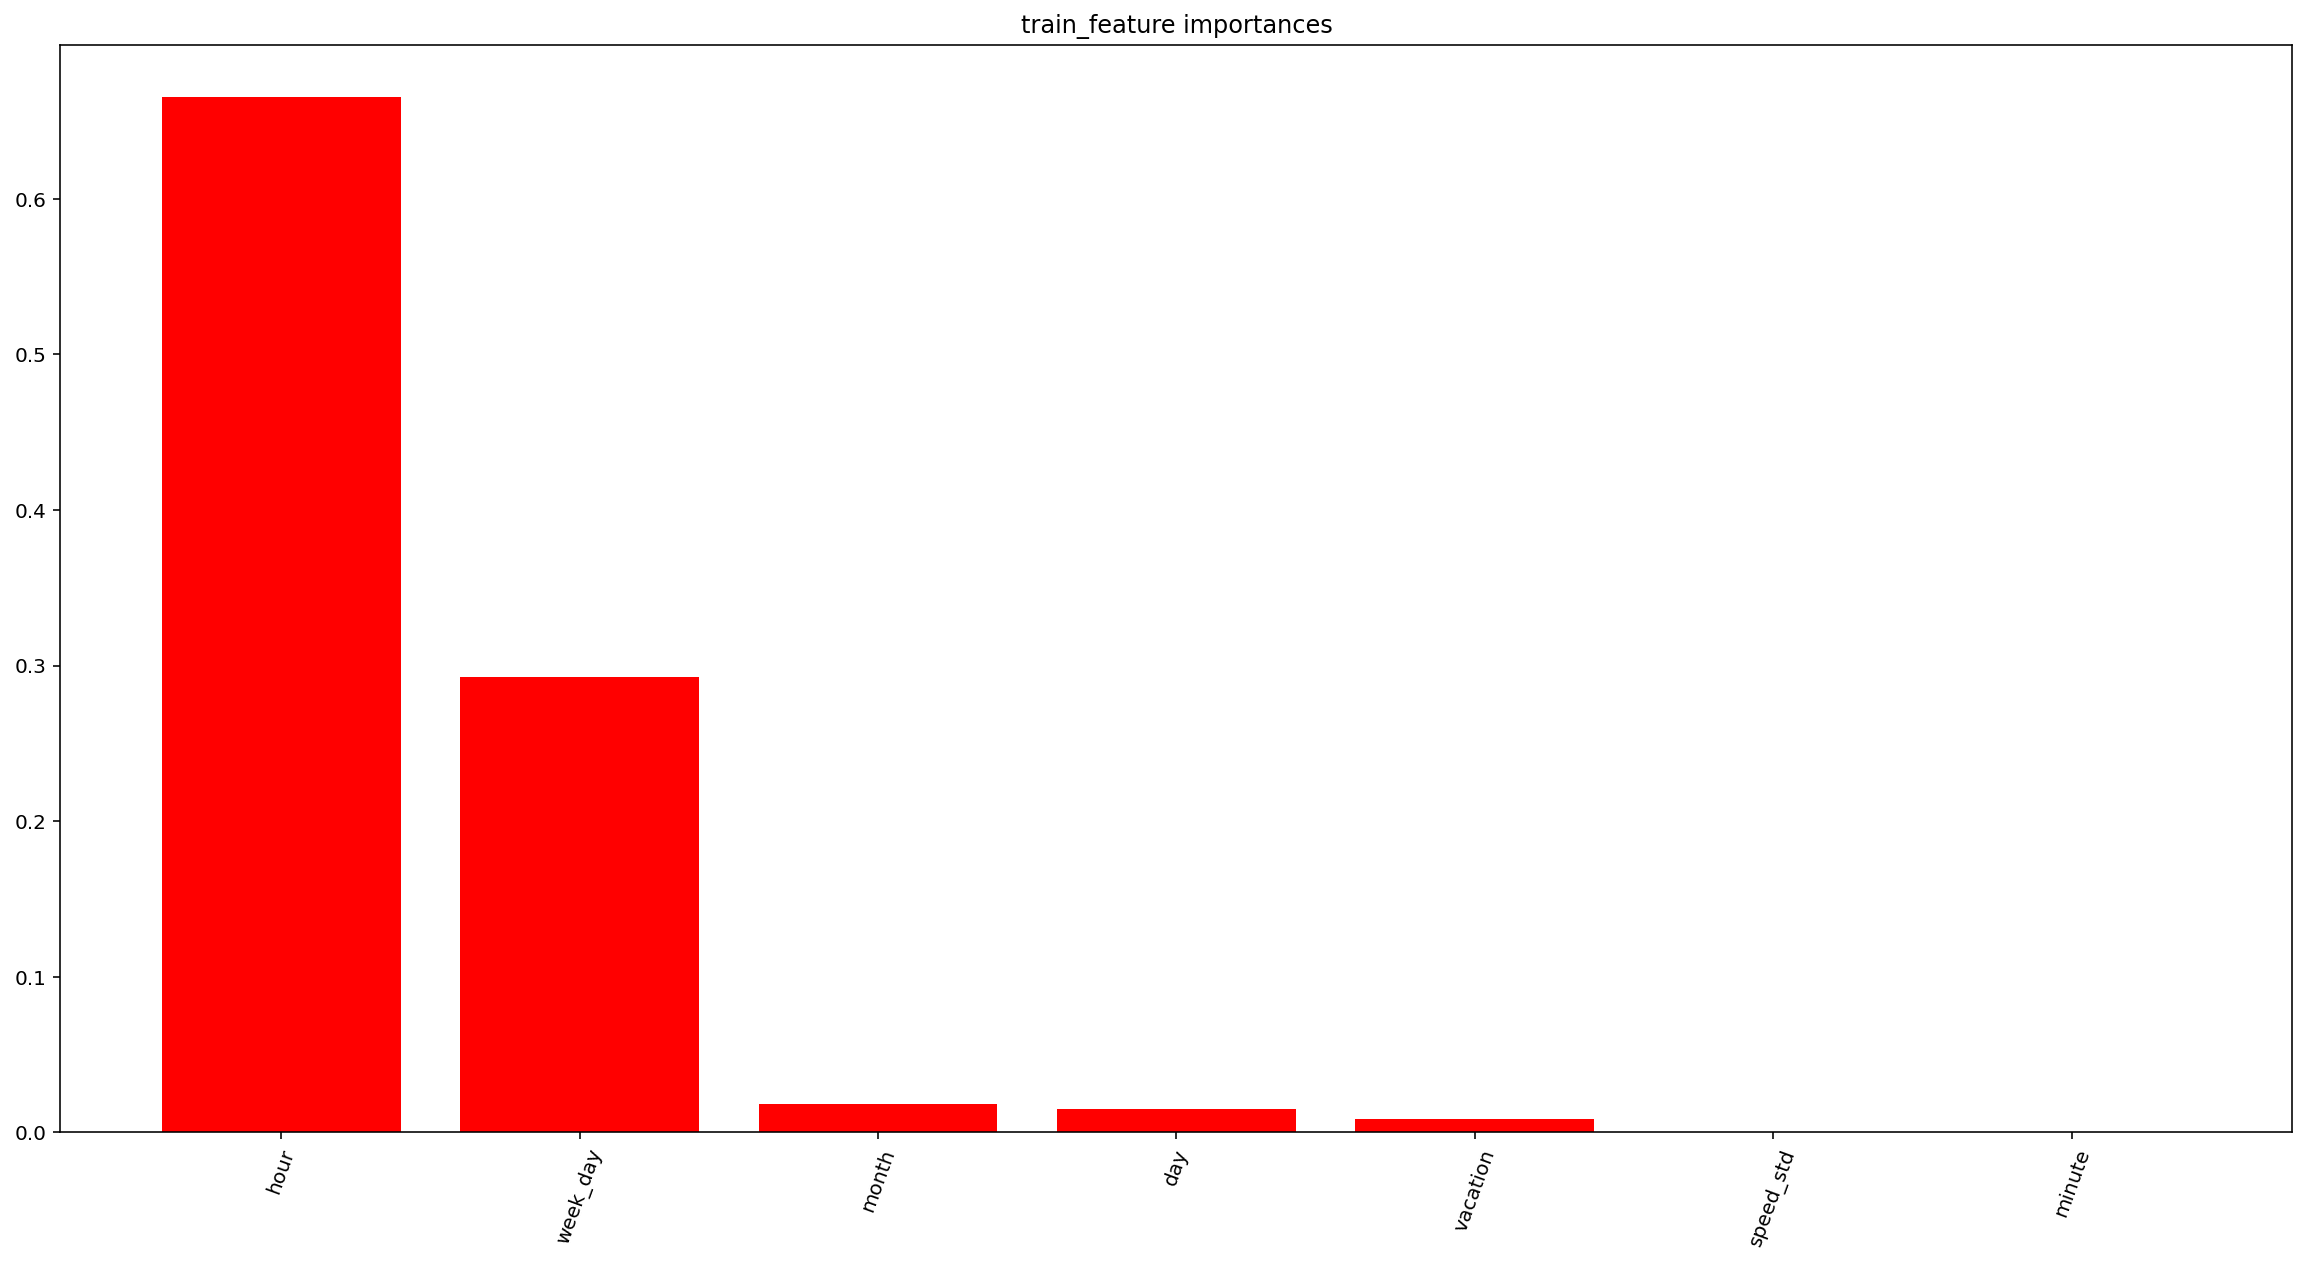

In [ ]:
outcome_train = pd.merge(train_data, test_df[['date', 'prediction']], on=['date'], how='left')

def feature_vis(regressor, train_feature):
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = [train_feature[e] for e in indices]
    plt.figure(figsize=(20, 10))
    plt.title("train_feature importances")
    plt.bar(range(len(train_feature)), importances[indices],
            color="r", align="center")
    plt.xticks(range(len(selected_features)), selected_features, rotation=70)
    plt.show()

feature_vis(regressor,train_feature)

outcome_train['imputation1'] = outcome_train['speed'].isnull()
outcome_train['speed'] = outcome_train['speed'].fillna(value=outcome_train['prediction'])
outcome_train['speed'] = (outcome_train['speed'] * np.array(outcome_train['speed_std']) + np.array(outcome_train['date_trend']))

In [ ]:
impu_speed = outcome_train[['date', 'speed', 'imputation1']]
date_mean = impu_speed[['date', 'speed']]
date_mean = date_mean.set_index('date')

mean_d = date_mean.resample('D').mean()
mean_max = date_mean.resample('D').max()
mean_min = date_mean.resample('D').min()

# speed feature
mean_d = mean_d.reset_index()
mean_d = mean_d.rename(columns={'date':'date_only'})
mean_d = mean_d.rename(columns={'speed':'speed_mean'})
mean_max = mean_max.reset_index()
mean_max = mean_max.rename(columns={'date':'date_only'})
mean_max = mean_max.rename(columns={'speed':'speed_max'})
mean_min = mean_min.reset_index()
mean_min = mean_min.rename(columns={'date':'date_only'})
mean_min = mean_min.rename(columns={'speed':'speed_min'})

# 5 size of speed windows
def create_lagging(df, df_original, i):
    df1 = df_original.copy()
    df1['date'] = df1['date'] + pd.DateOffset(hours=i)
    df1 = df1.rename(columns={'speed': 'lagging' + str(i)})
    df2 = pd.merge(df, df1[['date', 'lagging' + str(i)]],
                   on=['date'],
                   how='left')
    return df2

lagging = 5
feature_date = create_lagging(impu_speed, impu_speed, 1)
for i in range(2, lagging + 1):
    feature_date = create_lagging(feature_date, impu_speed, i)

feature_date['date_only'] = feature_date['date'].dt.date
feature_date['date_only']=pd.to_datetime(feature_date['date_only'],format='%Y-%m-%d')

feature_date = pd.merge(feature_date, mean_d, how='left', on='date_only')
feature_date = pd.merge(feature_date, mean_max, how='left', on='date_only')
feature_date = pd.merge(feature_date, mean_min, how='left', on='date_only')

feature_date.loc[feature_date['date_only'].isin(
    ['2017-01-01', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
     '2017-01-02', '2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
      '2017-05-28', '2017-05-29', '2017-05-30', '2018-01-01', '2018-02-15', '2018-02-16', 
     '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-04-07', 
     '2018-04-06', '2018-04-07', '2018-04-29', '2018-04-30', '2018-05-01', '2018-06-18',
     '2018-09-24', '2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05',
     '2018-10-06', '2018-10-07']), 'vacation'] = 1
feature_date.loc[~feature_date['date_only'].isin(
    ['2017-01-02', '2017-01-27', '2017-01-28', '2017-01-29', '2017-01-30', '2017-01-31', '2017-02-01',
     '2017-01-01', '2017-04-02', '2017-04-03', '2017-04-04', '2017-04-29', '2017-04-30', '2017-05-01',
      '2017-05-28', '2017-05-29', '2017-05-30', '2018-01-01', '2018-02-15', '2018-02-16', 
     '2018-02-17', '2018-02-18', '2018-02-19', '2018-02-20', '2018-02-21', '2018-04-07', 
     '2018-04-06', '2018-04-07', '2018-04-29', '2018-04-30', '2018-05-01', '2018-06-18',
     '2018-09-24', '2018-10-01', '2018-10-02', '2018-10-03', '2018-10-04', '2018-10-05',
     '2018-10-06', '2018-10-07']), 'vacation'] = 0

feature_date = feature_date.drop(['date_only'], axis=1)

feature_date['week_day'] = feature_date['date'].map(lambda x: x.weekday() + 1)
feature_date.loc[feature_date['week_day'].isin([1, 2, 3, 4, 5]), 'day_of_week_en'] = 1
feature_date.loc[feature_date['week_day'].isin([6]), 'day_of_week_en'] = 2
feature_date.loc[feature_date['week_day'].isin([7]), 'day_of_week_en'] = 3
# feature_date = pd.get_dummies(feature_date, columns=['week_day'])

feature_date.loc[feature_date['date'].dt.hour.isin([0, 1, 2, 3, 4, 5, 23]), 'mid_night'] = 1
feature_date.loc[feature_date['date'].dt.hour.isin([6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]), 'mid_night'] = 0

feature_date.loc[feature_date['date'].dt.hour.isin([7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19]), 'rush_time'] = 1
feature_date.loc[~feature_date['date'].dt.hour.isin([7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 19]), 'rush_time'] = 0

# feature_date.loc[feature_date['date'].dt.hour.isin([0, 1, 2, 3, 4, 5]), 'hour_en'] = 1
# feature_date.loc[feature_date['date'].dt.hour.isin([6, 7, 8,]), 'hour_en'] = 2
# feature_date.loc[feature_date['date'].dt.hour.isin([9, 10, 11]), 'hour_en'] = 3
# feature_date.loc[feature_date['date'].dt.hour.isin([12, 13, 14, 15, 16]), 'hour_en'] = 4
# feature_date.loc[feature_date['date'].dt.hour.isin([17, 18]), 'hour_en'] = 5
# feature_date.loc[feature_date['date'].dt.hour.isin([19, 20, 21]), 'hour_en'] = 6
# feature_date.loc[feature_date['date'].dt.hour.isin([22, 23]), 'hour_en'] = 7

feature_date['hour'] = feature_date['date'].dt.hour
feature_date['day'] = feature_date['date'].dt.day
feature_date['month'] = feature_date['date'].dt.month

# feature_date['week_hour'] = feature_date["day_of_week_en"].astype('str') + "," + feature_date["hour_en"].astype('str')
# feature_date = pd.get_dummies(feature_date, columns=['week_hour'])

lagging = 5
lagging_feature = ['lagging%01d' % e for e in range(lagging, 0, -1)]
base_feature = [x for x in feature_date.columns.values.tolist() if x not in ['date', 'speed', 'imputation1']]
base_feature = [x for x in base_feature if x not in lagging_feature]
train_feature1 = list(base_feature)
train_feature1.extend(lagging_feature)
valid_feature = list(base_feature)
valid_feature.extend(['speed'])

train_main = feature_date
# train_main = feature_date.loc[feature_date['date'] <= "2017-12-31 23:00:00"]
test_main = feature_date.loc[feature_date['date'] > "2017-12-31 23:00:00"]

X = train_main[train_feature1].values
y = train_main['speed'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

eval_set = [(X_test, y_test)]
regressor2 = xgb.XGBRegressor(max_depth=8, n_estimators=800, min_child_weight=1, subsample=0.9, colsample_bytree=0.5, gamma=0)
regressor2.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_train, y_train), (X_test, y_test)])
test_main['prediction'] = regressor2.predict(test_main[train_feature1].values)

[04:18:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:31.5342	validation_1-rmse:31.2461
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:28.4295	validation_1-rmse:28.1665
[2]	validation_0-rmse:25.6312	validation_1-rmse:25.3878
[3]	validation_0-rmse:23.1209	validation_1-rmse:22.902
[4]	validation_0-rmse:20.8716	validation_1-rmse:20.675
[5]	validation_0-rmse:18.84	validation_1-rmse:18.6645
[6]	validation_0-rmse:17.025	validation_1-rmse:16.8674
[7]	validation_0-rmse:15.4195	validation_1-rmse:15.2818
[8]	validation_0-rmse:13.961	validation_1-rmse:13.8502
[9]	validation_0-rmse:12.6375	validation_1-rmse:12.546
[10]	validation_0-rmse:11.4453	validation_1-rmse:11.3777
[11]	validation_0-rmse:10.3948	validation_1-rmse:10.3524
[12]	validation_0-rmse:9.438	validation_1-rmse:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


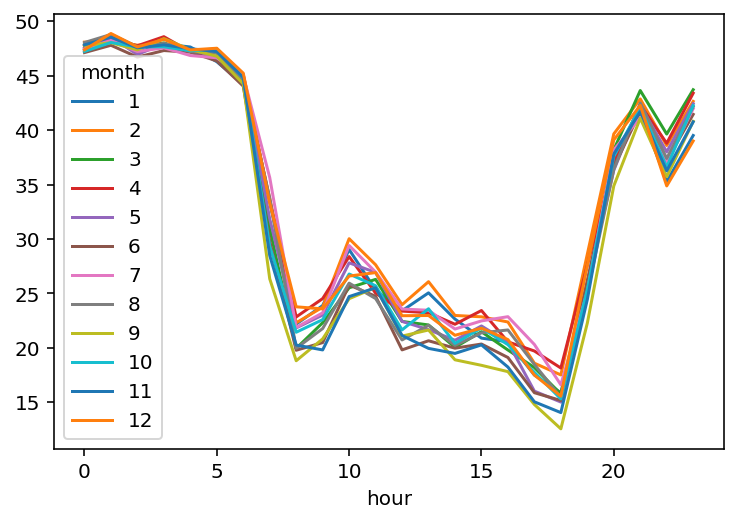

In [ ]:
feature_date.loc[feature_date['date'].dt.year.isin([2017])].groupby(['hour', 'month'])[
    'speed'].mean().unstack().plot()
plt.show()

In [ ]:
result_train = pd.merge(feature_date, test_main[['date', 'prediction']], on=['date'],
              how='left')
result_sub = result_train[result_train['date'] > "2017-12-31 23:00:00"]
result_sub = result_sub[result_sub['imputation1'] == True]
result_sub = result_sub[['date', 'prediction']]
result_sub['date'] = result_sub.date.map(lambda x: x.strftime('%d/%m/%Y %H:%M'))
result_sub.to_csv("/content/gdrive/My Drive/5001/individual_project/sampleSubmission_3.02.csv", index_label="index_label")

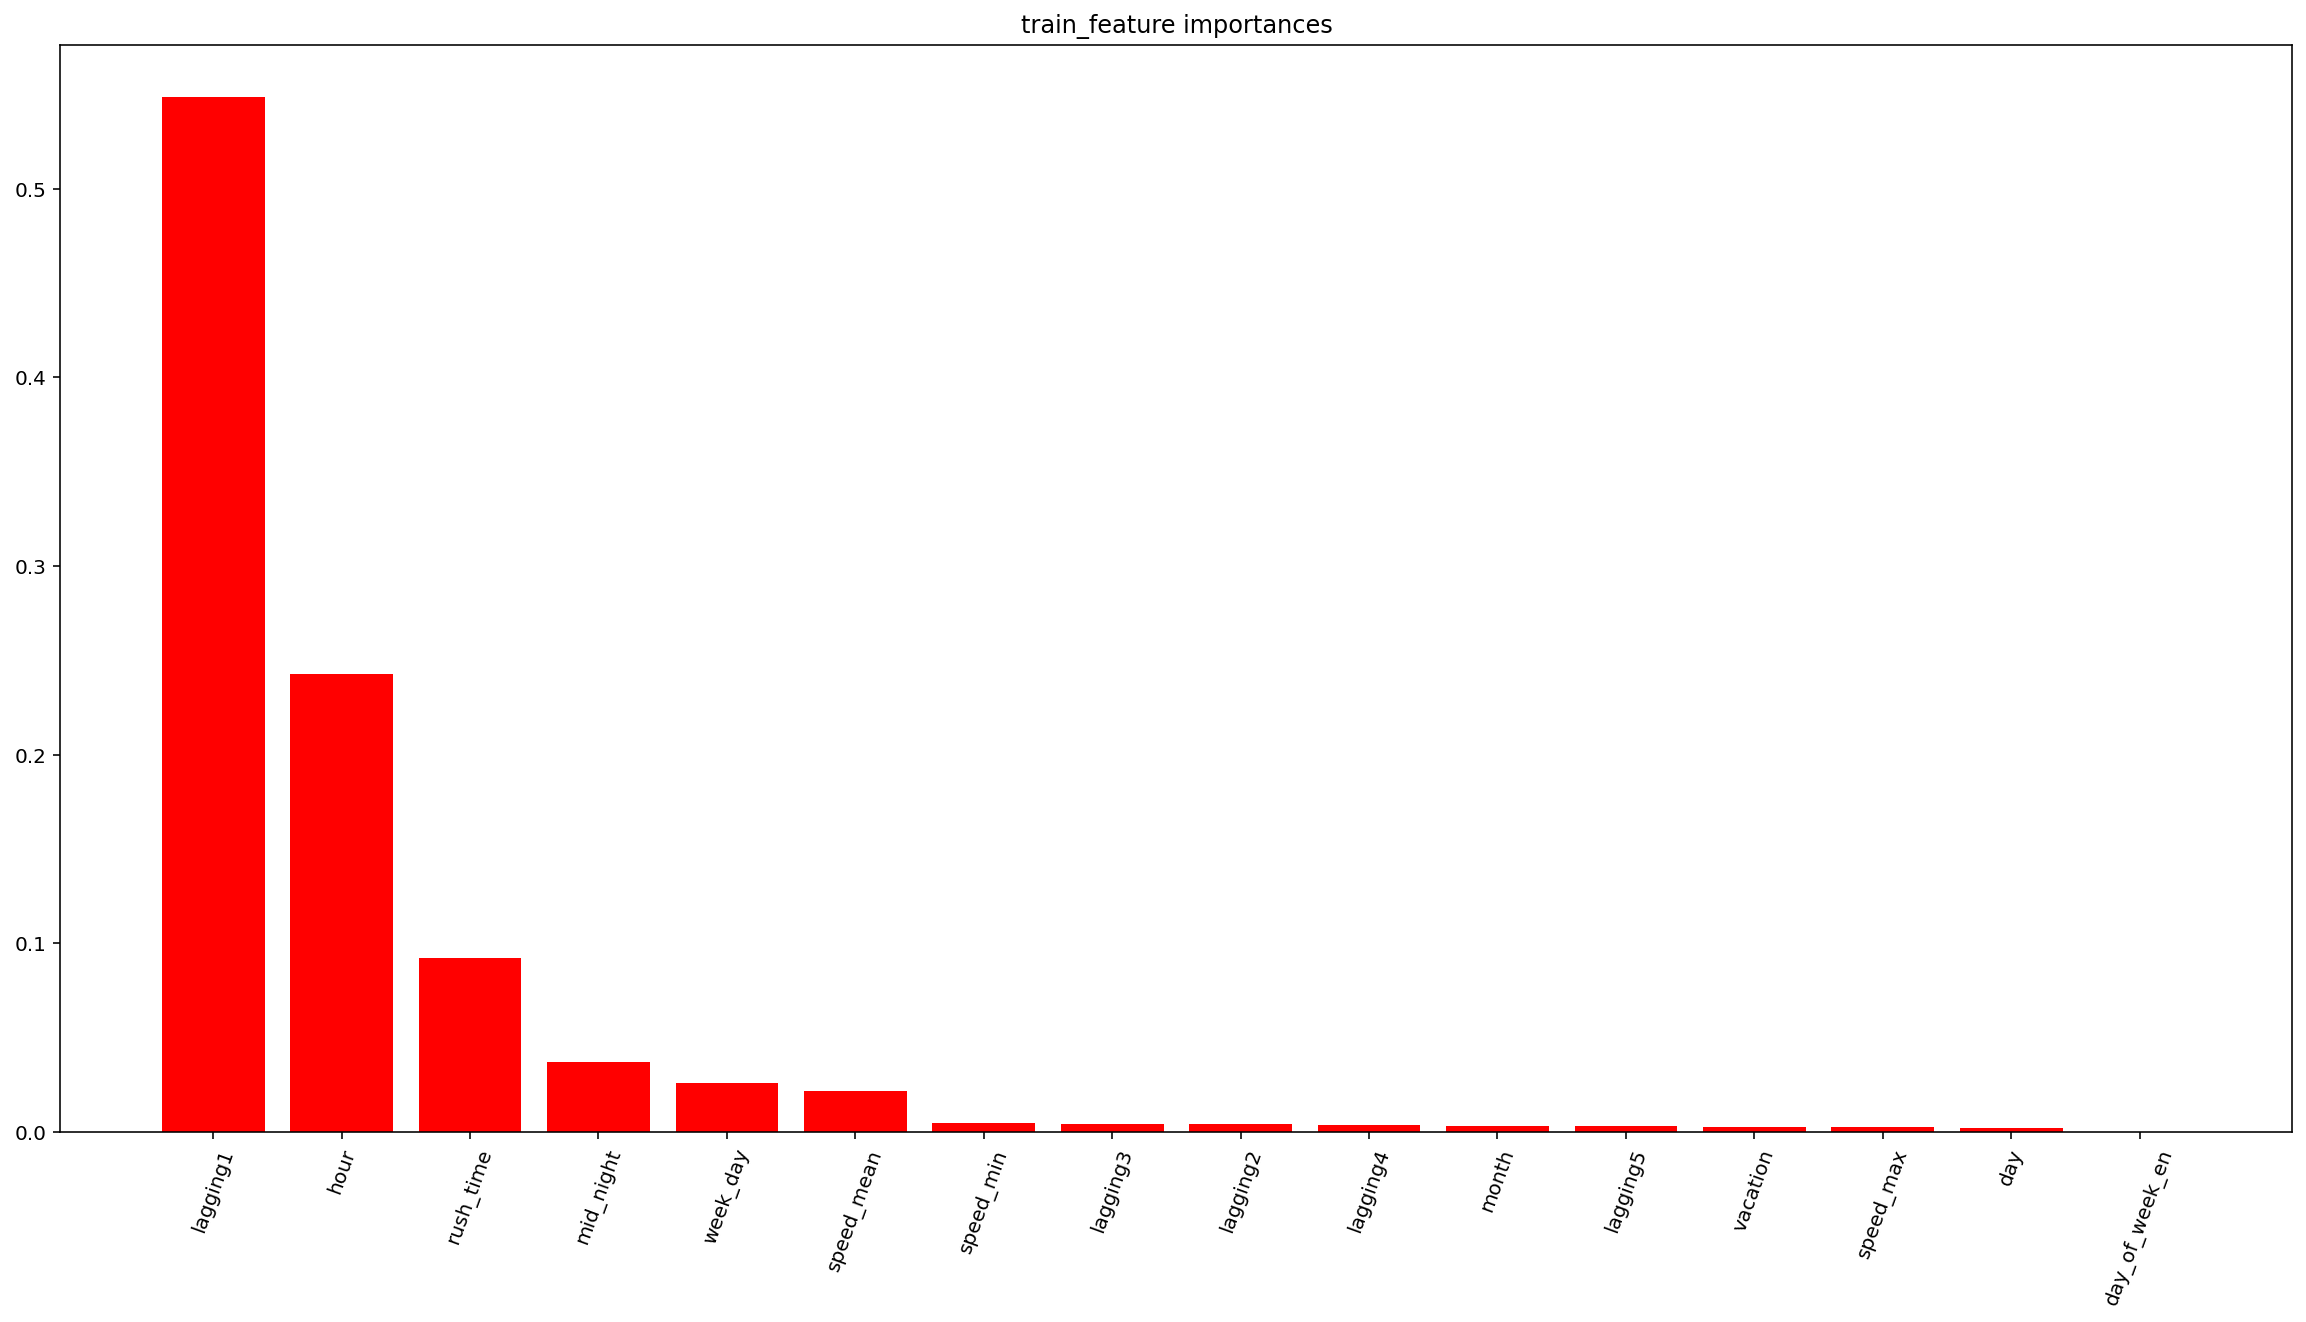

In [ ]:
def feature_vis(regressor, train_feature):
    importances = regressor.feature_importances_
    indices = np.argsort(importances)[::-1]
    selected_features = [train_feature[e] for e in indices]
    plt.figure(figsize=(20, 10))
    plt.title("train_feature importances")
    plt.bar(range(len(train_feature)), importances[indices],
            color="r", align="center")
    plt.xticks(range(len(selected_features)), selected_features, rotation=70)
    plt.show()

feature_vis(regressor2,train_feature1)